### Task C- 3 Visualizations 

### Streaming data visualizations

In [ ]:
# import statements
from time import sleep
from kafka import KafkaConsumer
import datetime as dt
import matplotlib.pyplot as plt
import json
# this line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

topic = 'climate_data'

def annotate_max(x, y, ax = None):
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max: Time={}, Value={}'.format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor='red', shrink=0.05),)
    
def annotate_min(x, y, ax = None):
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min: Time={}, Value={}'.format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor='orange', shrink=0.05),)

def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=10000, # stop iteration if no message after 10 sec
                                   auto_offset_reset='earliest', # comment this if you don't want to consume earliest available message
                                   bootstrap_servers=['localhost:9092'],
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle('Real-time uniform stream data visualization with interesting points') # giving figure a title
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
        ax.set_ylim(0,110) 
        ax.set_yticks([0,20,40,60,80,100])
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))
    
def consume_messages(consumer, fig, ax):
    try:
        # container for x and y values
        x, y = [], []
        # print('Waiting for messages')
        for message in consumer:
            data = (message.value.decode('utf-8'))
#             Loading the received data sent by the producer

            dataset= json.loads(data)
            if(dataset["sender_id"]==1):
                x.append(str(dataset["timestamp"]))
                y.append(int(dataset["air_temperature_celcius"]))
                # print(y)
                # we start plotting only when we have 10 data points
                if len(y) > 10:
                    ax.clear()
                    ax.plot(x, y)
                    ax.set_xlabel('Time')
                    ax.set_ylabel('Value')
                    ax.set_ylim(0,110) 
                    ax.set_yticks([0,20,40,60,80,100])
                    annotate_max(x,y)
                    annotate_min(x,y)
                    fig.canvas.draw()
                    x.pop(0) # removing the item in the first position
                    y.pop(0)
        plt.close('all')
    except Exception as ex:
        print(str(ex))
    
if __name__ == '__main__':
    
    consumer = connect_kafka_consumer()
    fig, ax = init_plots()
    consume_messages(consumer, fig, ax)
    
    

## Static data visualizations

### Records with top 10 fire incidents in a bar chart

In [12]:
# Import contents
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
import pymongo
from pymongo import MongoClient


client = MongoClient () # method 1: connect on the default host and port

# client.drop_database('fit5148_assignment_db')
db=client['fit5148_assignment_db']


<BarContainer object of 10 artists>

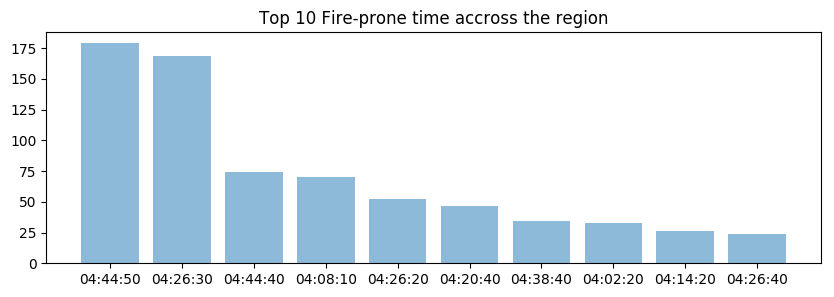

In [13]:
# import libraries
import matplotlib.pyplot as plt; 
import numpy as np
import matplotlib.pyplot as plt
import pymongo
from pymongo import MongoClient
from dateutil import parser

client = MongoClient () # method 1: connect on the default host and port

db=client['fit5148_assignment_db']

datearrr=[]
countarr=[]
result=db['hotspot_historic'].aggregate([{"$group":{"_id":"$datetime", "count": {"$sum":1}}},{"$sort":{"count":-1}},{"$limit": 10}])
# Getting data and appending to arrayys for axes
for document in result: 
    dt = parser.parse(document['_id'])  
    datearrr.append(str(dt.time()))
    countarr.append(document['count'])

#     Plotting bar chart
plt.figure(figsize=(10,3))
plt.title("Top 10 Fire-prone time accross the region")
plt.bar(datearrr, countarr, align='center', alpha=0.5)

# 

# https://pythonspot.com/matplotlib-bar-chart/

### Plot data with fire visualizations

In [14]:
import gmplot
from pymongo import MongoClient
import webbrowser

# gmplot contains a simple wrapper around 
# Google’s geocoding service enabling map initilization to the location of your choice.
unoccupiedList=[]
client = MongoClient()
db=client['fit5148_assignment_db']
res=db['hotspot_historic'].aggregate([
    {"$lookup":
     {"from": "climate_historic",
      "localField": "date",
      "foreignField" : "date" ,
      "as":"climate_historic"
     }
    },

   {"$project" : {"datetime":1,"latitude":1,"longitude":1,
                  "surface_temperature_celcius":1, "confidence":1,"climate_historic.air_temperature_celcius":1,"climate_historic.relative_humidity":1
                                             }}
])


for row in res:
    obj=(row['climate_historic'])[0]
    unoccupiedList.append((float(row['latitude']), float(row['longitude'])
                        ,float(row['surface_temperature_celcius'])
                        ,float(row['confidence']),float((obj['relative_humidity']))
                        ,float((obj['air_temperature_celcius']))))



print(len(unoccupiedList))
# The step below is required by the gmap scatter function to prepare data in correct format
unoccupied_lats, unoccupied_lons,hstc,conf,relative_humidity,airtemp = zip(*unoccupiedList) 

gmap = gmplot.GoogleMapPlotter(-37.812015244225677, 144.951471202974, 15) # latitude and longitude of melbourne city
for i in range(0,len(unoccupiedList)):
    gmap.marker(unoccupied_lats[i], unoccupied_lons[i],title="surface temp:"+str(hstc[i])+
                " confidence:"+str(conf[i])+" air temp:"+str(airtemp[i])+" relative humidity:"+str(relative_humidity[i]))

# print(len(unoccupied_lats),len(unoccupied_lons),len(airtemp),len(relative_humidity,hstc)

# Plotting the points on the map
# gmap.scatter(unoccupied_lats, unoccupied_lons, '#FF4500', size=2, marker=False)


# Drawing the map
gmap.draw("availableParkings.html")
webbrowser.open_new("availableParkings.html")

2668


True